In [ ]:
#XGBOOST
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# (Re‐use your existing df that already has:)
#  • 'n', 'V', 'BY', 'BZ'
#  • 'ssi_lag1', 'ssi_lag24', 'ssi_lag288'
#  • 'V_roll1h', 'BY_roll1h', 'BZ_roll1h', 'n_roll1h'
#  • 'V_std4h', 'BY_std4h', 'BZ_std4h', 'n_std4h'
#  • 'ssi_59.5nm' (the true target)

# If you haven’t yet, you can reconstruct that df exactly as before:
df = pd.read_csv("/final_train_cleaned_2008_2015.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# Re‐create all lagged and rolling features (to be safe):
df['ssi_lag1']   = df['ssi_59.5nm'].shift(1).fillna(method='bfill')
df['ssi_lag24']  = df['ssi_59.5nm'].shift(24).fillna(method='bfill')
df['ssi_lag288'] = df['ssi_59.5nm'].shift(288).fillna(method='bfill')

df['V_roll1h']   = df['V'].rolling(window=12).mean().fillna(method='bfill')
df['BY_roll1h']  = df['BY'].rolling(window=12).mean().fillna(method='bfill')
df['BZ_roll1h']  = df['BZ'].rolling(window=12).mean().fillna(method='bfill')
df['n_roll1h']   = df['n'].rolling(window=12).mean().fillna(method='bfill')

df['V_std4h']    = df['V'].rolling(window=48).std().fillna(method='bfill')
df['BY_std4h']   = df['BY'].rolling(window=48).std().fillna(method='bfill')
df['BZ_std4h']   = df['BZ'].rolling(window=48).std().fillna(method='bfill')
df['n_std4h']    = df['n'].rolling(window=48).std().fillna(method='bfill')

# Drop the first 288 rows so that all lag‐288 values are valid
df = df.iloc[288:].reset_index(drop=True)

# Define feature columns and target
feature_cols = [
    'n', 'V', 'BY', 'BZ',
    'ssi_lag1', 'ssi_lag24', 'ssi_lag288',
    'V_roll1h', 'BY_roll1h', 'BZ_roll1h', 'n_roll1h',
    'V_std4h', 'BY_std4h', 'BZ_std4h', 'n_std4h'
]
target_col = 'ssi_59.5nm'

# Build numpy arrays
X_tab = df[feature_cols].values
y_tab = df[target_col].values

# Split 80% train / 20% test in time order
split_idx = int(0.8 * len(df))
X_train_tab, X_test_tab = X_tab[:split_idx], X_tab[split_idx:]
y_train_tab, y_test_tab = y_tab[:split_idx], y_tab[split_idx:]


<ipython-input-12-e4fde5488336>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ssi_lag1']   = df['ssi_59.5nm'].shift(1).fillna(method='bfill')
<ipython-input-12-e4fde5488336>:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ssi_lag24']  = df['ssi_59.5nm'].shift(24).fillna(method='bfill')
<ipython-input-12-e4fde5488336>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ssi_lag288'] = df['ssi_59.5nm'].shift(288).fillna(method='bfill')
<ipython-input-12-e4fde5488336>:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['V_roll1h']   = df['V'].rolling(window=12).mean().fillna(method='bfill')
<ipython-input-12-e4fde5488336>:2

XGBoost Performance on Test Data:
  • MSE_xgb: 3485596878891194.50
  • MAE_xgb: 26658776.03
  • R²_xgb:  0.9810


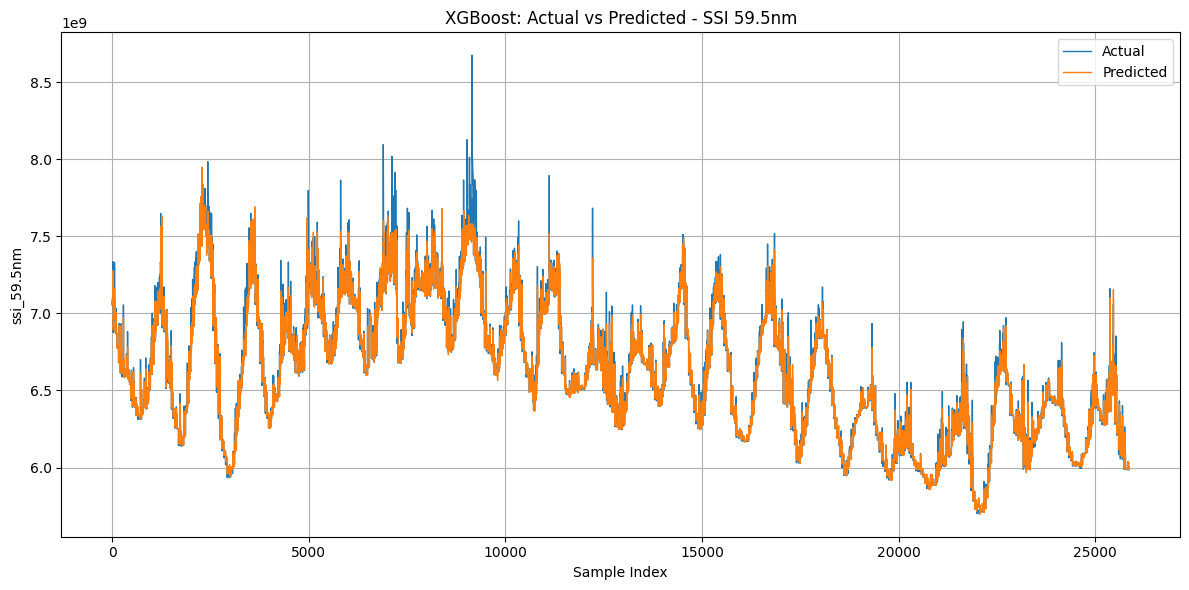

In [ ]:
# 1) Instantiate the model
bst = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    tree_method='hist'  # you can also try 'gpu_hist' if GPU is available
)

# 2) Fit on the training data
bst.fit(X_train_tab, y_train_tab)

# 3) Predict on test set
y_pred_xgb = bst.predict(X_test_tab)

# 4) Compute metrics
mse_xgb = mean_squared_error(y_test_tab, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_tab, y_pred_xgb)
r2_xgb  = r2_score(y_test_tab, y_pred_xgb)

print("XGBoost Performance on Test Data:")
print(f"  • MSE_xgb: {mse_xgb:.2f}")
print(f"  • MAE_xgb: {mae_xgb:.2f}")
print(f"  • R²_xgb:  {r2_xgb:.4f}")

# 5) Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_tab, label='Actual', linewidth=1)
plt.plot(y_pred_xgb, label='Predicted', linewidth=1)
plt.title('XGBoost: Actual vs Predicted - SSI 59.5nm')
plt.xlabel('Sample Index')
plt.ylabel('ssi_59.5nm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-20-f9c338e0e849>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ssi_lag1']   = df['ssi_59.5nm'].shift(1).fillna(method='bfill')
<ipython-input-20-f9c338e0e849>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ssi_lag24']  = df['ssi_59.5nm'].shift(24).fillna(method='bfill')
<ipython-input-20-f9c338e0e849>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ssi_lag288'] = df['ssi_59.5nm'].shift(288).fillna(method='bfill')
<ipython-input-20-f9c338e0e849>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['V_roll1h']   = df['V'].rolling(window=12).mean().fillna(method='bfill')
<ipython-input-20-f9c338e0e849>:1


📊 AdaBoost Performance:
  • MSE: 11652680856817982.00
  • MAE: 83261167.66
  • R²:  0.9366

📊 CatBoost Performance:
  • MSE: 3299613753461840.50
  • MAE: 27862653.63
  • R²:  0.9821


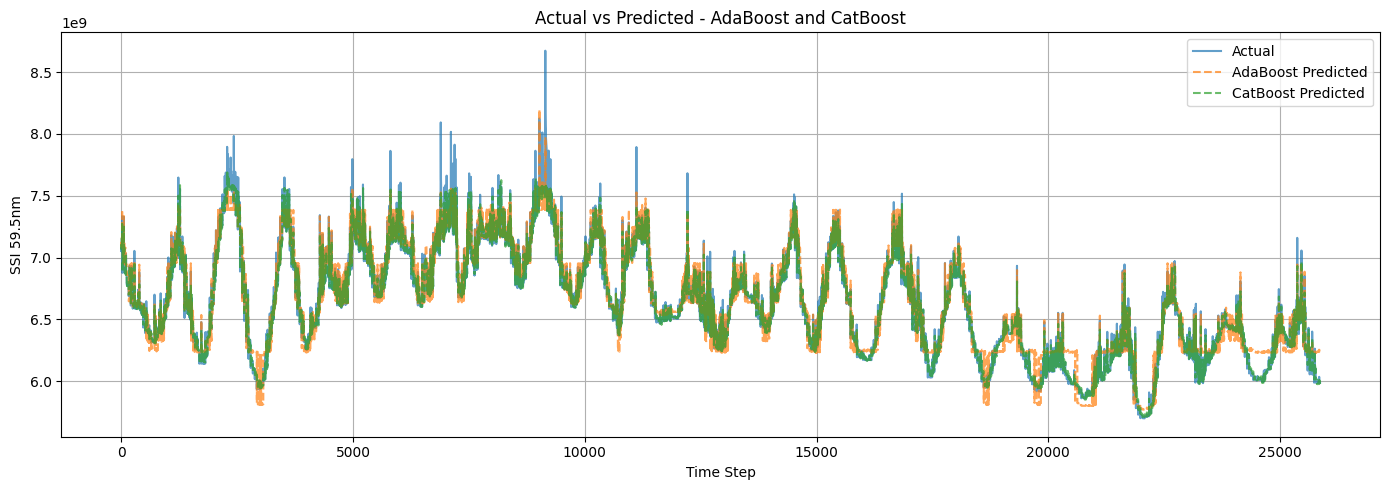

In [ ]:
#ADAB00ST&CATBOOST
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

# Load and prepare data
df = pd.read_csv("/content/final_train_cleaned_2008_2015.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# Feature Engineering (same as before)
df['ssi_lag1']   = df['ssi_59.5nm'].shift(1).fillna(method='bfill')
df['ssi_lag24']  = df['ssi_59.5nm'].shift(24).fillna(method='bfill')
df['ssi_lag288'] = df['ssi_59.5nm'].shift(288).fillna(method='bfill')

df['V_roll1h']   = df['V'].rolling(window=12).mean().fillna(method='bfill')
df['BY_roll1h']  = df['BY'].rolling(window=12).mean().fillna(method='bfill')
df['BZ_roll1h']  = df['BZ'].rolling(window=12).mean().fillna(method='bfill')
df['n_roll1h']   = df['n'].rolling(window=12).mean().fillna(method='bfill')

df['V_std4h']    = df['V'].rolling(window=48).std().fillna(method='bfill')
df['BY_std4h']   = df['BY'].rolling(window=48).std().fillna(method='bfill')
df['BZ_std4h']   = df['BZ'].rolling(window=48).std().fillna(method='bfill')
df['n_std4h']    = df['n'].rolling(window=48).std().fillna(method='bfill')

# Drop initial rows with NaNs
df = df.iloc[288:].reset_index(drop=True)

# Features and Target
feature_cols = [
    'n', 'V', 'BY', 'BZ',
    'ssi_lag1', 'ssi_lag24', 'ssi_lag288',
    'V_roll1h', 'BY_roll1h', 'BZ_roll1h', 'n_roll1h',
    'V_std4h', 'BY_std4h', 'BZ_std4h', 'n_std4h'
]
target_col = 'ssi_59.5nm'

X_tab = df[feature_cols].values
y_tab = df[target_col].values

# Train-Test Split
split_idx = int(0.8 * len(df))
X_train_tab, X_test_tab = X_tab[:split_idx], X_tab[split_idx:]
y_train_tab, y_test_tab = y_tab[:split_idx], y_tab[split_idx:]

# ========== 1. AdaBoost ==========
ada = AdaBoostRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
ada.fit(X_train_tab, y_train_tab)
y_pred_ada = ada.predict(X_test_tab)

mse_ada = mean_squared_error(y_test_tab, y_pred_ada)
mae_ada = mean_absolute_error(y_test_tab, y_pred_ada)
r2_ada  = r2_score(y_test_tab, y_pred_ada)

print("\n📊 AdaBoost Performance:")
print(f"  • MSE: {mse_ada:.2f}")
print(f"  • MAE: {mae_ada:.2f}")
print(f"  • R²:  {r2_ada:.4f}")

# ========== 2. CatBoost ==========
cat = CatBoostRegressor(iterations=300, depth=6, learning_rate=0.05, verbose=0, random_seed=42)
cat.fit(X_train_tab, y_train_tab)
y_pred_cat = cat.predict(X_test_tab)

mse_cat = mean_squared_error(y_test_tab, y_pred_cat)
mae_cat = mean_absolute_error(y_test_tab, y_pred_cat)
r2_cat  = r2_score(y_test_tab, y_pred_cat)

print("\n📊 CatBoost Performance:")
print(f"  • MSE: {mse_cat:.2f}")
print(f"  • MAE: {mae_cat:.2f}")
print(f"  • R²:  {r2_cat:.4f}")

# ========== Plot Predictions ==========
plt.figure(figsize=(14, 5))
plt.plot(y_test_tab, label="Actual", alpha=0.7)
plt.plot(y_pred_ada, label="AdaBoost Predicted", linestyle='--', alpha=0.7)
plt.plot(y_pred_cat, label="CatBoost Predicted", linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted - AdaBoost and CatBoost")
plt.xlabel("Time Step")
plt.ylabel("SSI 59.5nm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
